# Load models

In [1]:
import os
import sys
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

cwd = os.getcwd()
module_path = "/".join(cwd.split('/')[0:-1])
if module_path not in sys.path:
    sys.path.append(module_path)

# Network architectures
from net.lenet import lenet
from net.resnet import resnet18
from net.vgg import vgg16

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Load LeNet model
lenet_model = lenet().to(device)
lenet_model = nn.DataParallel(lenet_model, device_ids=range(torch.cuda.device_count()))
cudnn.benchmark = True
lenet_model.load_state_dict(torch.load("./lenet_1_100.model"))

# Load ResNet-18 model
resnet18_sn_model = resnet18(spectral_normalization=True,
                             mod = False,
                             mnist = True).to(device)
resnet18_sn_model = nn.DataParallel(resnet18_sn_model, device_ids=range(torch.cuda.device_count()))
resnet18_sn_model.load_state_dict(torch.load("./resnet18_sn_3.0_1_100.model"))

# Load VGG-16 model
vgg16_model = vgg16(spectral_normalization = False,
                    mod = False,
                    mnist = True).to(device)
vgg16_model = nn.DataParallel(vgg16_model, device_ids=range(torch.cuda.device_count()))
vgg16_model.load_state_dict(torch.load("./vgg16_1_100.model"))

<All keys matched successfully>

# Compute softmax entropy & feature density

In [4]:
from tqdm import tqdm
from data.fast_mnist import create_MNIST_dataset
from data.ambiguous_mnist.ambiguous_mnist import get_loaders
from data.dirty_mnist import get_train_valid_loader, get_test_loader
import data.fashion_mnist as fashion_mnist

import metrics.uncertainty_confidence as uncertainty_confidence

from utils.gmm_utils import get_embeddings, gmm_fit, gmm_evaluate

In [5]:
num_classes = 10
batch_size = 128

# MNIST data loader
_, mnist_test_dataset = create_MNIST_dataset()
mnist_loader = torch.utils.data.DataLoader(mnist_test_dataset,
                                           batch_size=batch_size,
                                           num_workers=0,
                                           shuffle=False)

# Ambiguous MNIST data loader
ambiguous_mnist_loader = get_loaders(root='/home/jishnu/Projects/OATML/DDU/code/',
                                     train=False,
                                     batch_size=batch_size)

# Dirty MNIST data loader
dirty_mnist_train_loader, dirty_mnist_val_loader = get_train_valid_loader(root='/home/jishnu/Projects/OATML/DDU/code/',
                                                                          batch_size=batch_size)
dirty_mnist_loader = get_test_loader(root='/home/jishnu/Projects/OATML/DDU/code/',
                                     batch_size=batch_size)

# Fashion MNIST data loader
fashion_mnist_loader = fashion_mnist.get_loaders(batch_size=batch_size,
                                                 train=False)

In [6]:
def get_logits (model, data_loader, device):
    logits = []
    model.eval()
    with torch.no_grad():
        for (data, label) in tqdm(data_loader):
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            logits.append(output)
        
    logits = torch.cat(logits, dim=0)
    return logits


def train_gmm(model, num_dim, train_loader, device):
    embeddings, labels = get_embeddings(model,
                                        train_loader,
                                        num_dim,
                                        dtype=torch.double,
                                        device=device,
                                        storage_device=device)
    gaussians_model, jitter_eps = gmm_fit(embeddings=embeddings,
                                          labels=labels,
                                          num_classes=10)
    return gaussians_model


def get_gmm_logits(model, gmm_model, data_loader, device):
    gmm_logits, gmm_labels = gmm_evaluate(model,
                                          gmm_model,
                                          data_loader,
                                          device=device,
                                          num_classes=10,
                                          storage_device=device)
    return gmm_logits

In [7]:
# Computing entropies for LeNet
lenet_mnist_entropies = uncertainty_confidence.entropy(
    get_logits(lenet_model, mnist_loader, device)
)
lenet_ambiguous_mnist_entropies = uncertainty_confidence.entropy(
    get_logits(lenet_model, ambiguous_mnist_loader, device)
)
lenet_dirty_mnist_entropies = uncertainty_confidence.entropy(
    get_logits(lenet_model, dirty_mnist_loader, device)
)
lenet_fashion_mnist_entropies = uncertainty_confidence.entropy(
    get_logits(lenet_model, fashion_mnist_loader, device)
)

# Computing GMM densities for LeNet
lenet_gmm_model = train_gmm(lenet_model, 84, dirty_mnist_train_loader, device)
lenet_mnist_densities = uncertainty_confidence.logsumexp(
    get_gmm_logits(lenet_model, lenet_gmm_model, mnist_loader, device)
)
lenet_ambiguous_mnist_densities = uncertainty_confidence.logsumexp(
    get_gmm_logits(lenet_model, lenet_gmm_model, ambiguous_mnist_loader, device)
)
lenet_dirty_mnist_densities = uncertainty_confidence.logsumexp(
    get_gmm_logits(lenet_model, lenet_gmm_model, dirty_mnist_loader, device)
)
lenet_fashion_mnist_densities = uncertainty_confidence.logsumexp(
    get_gmm_logits(lenet_model, lenet_gmm_model, fashion_mnist_loader, device)
)

100%|██████████| 79/79 [00:00<00:00, 160.59it/s]


In [8]:
# Computing entropies for ResNet18-SN
resnet18_sn_mnist_entropies = uncertainty_confidence.entropy(
    get_logits(resnet18_sn_model, mnist_loader, device)
)
resnet18_sn_ambiguous_mnist_entropies = uncertainty_confidence.entropy(
    get_logits(resnet18_sn_model, ambiguous_mnist_loader, device)
)
resnet18_sn_dirty_mnist_entropies = uncertainty_confidence.entropy(
    get_logits(resnet18_sn_model, dirty_mnist_loader, device)
)
resnet18_sn_fashion_mnist_entropies = uncertainty_confidence.entropy(
    get_logits(resnet18_sn_model, fashion_mnist_loader, device)
)

# Computing GMM densities for resnet18_sn
resnet18_sn_gmm_model = train_gmm(resnet18_sn_model, 512, dirty_mnist_train_loader, device)
resnet18_sn_mnist_densities = uncertainty_confidence.logsumexp(
    get_gmm_logits(resnet18_sn_model, resnet18_sn_gmm_model, mnist_loader, device)
)
resnet18_sn_ambiguous_mnist_densities = uncertainty_confidence.logsumexp(
    get_gmm_logits(resnet18_sn_model, resnet18_sn_gmm_model, ambiguous_mnist_loader, device)
)
resnet18_sn_dirty_mnist_densities = uncertainty_confidence.logsumexp(
    get_gmm_logits(resnet18_sn_model, resnet18_sn_gmm_model, dirty_mnist_loader, device)
)
resnet18_sn_fashion_mnist_densities = uncertainty_confidence.logsumexp(
    get_gmm_logits(resnet18_sn_model, resnet18_sn_gmm_model, fashion_mnist_loader, device)
)

100%|██████████| 79/79 [00:02<00:00, 30.80it/s]


In [9]:
# Computing entropies for VGG-16
vgg16_mnist_entropies = uncertainty_confidence.entropy(
    get_logits(vgg16_model, mnist_loader, device)
)
vgg16_ambiguous_mnist_entropies = uncertainty_confidence.entropy(
    get_logits(vgg16_model, ambiguous_mnist_loader, device)
)
vgg16_dirty_mnist_entropies = uncertainty_confidence.entropy(
    get_logits(vgg16_model, dirty_mnist_loader, device)
)
vgg16_fashion_mnist_entropies = uncertainty_confidence.entropy(
    get_logits(vgg16_model, fashion_mnist_loader, device)
)

# Computing GMM densities for vgg16
vgg16_gmm_model = train_gmm(vgg16_model, 512, dirty_mnist_train_loader, device)
vgg16_mnist_densities = uncertainty_confidence.logsumexp(
    get_gmm_logits(vgg16_model, vgg16_gmm_model, mnist_loader, device)
)
vgg16_ambiguous_mnist_densities = uncertainty_confidence.logsumexp(
    get_gmm_logits(vgg16_model, vgg16_gmm_model, ambiguous_mnist_loader, device)
)
vgg16_dirty_mnist_densities = uncertainty_confidence.logsumexp(
    get_gmm_logits(vgg16_model, vgg16_gmm_model, dirty_mnist_loader, device)
)
vgg16_fashion_mnist_densities = uncertainty_confidence.logsumexp(
    get_gmm_logits(vgg16_model, vgg16_gmm_model, fashion_mnist_loader, device)
)

100%|██████████| 79/79 [00:03<00:00, 26.23it/s]


# Plot softmax entropy & feature density

In [10]:
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
from matplotlib import rc

In [11]:
from dataclasses import dataclass

os.makedirs("./pdfs")
os.makedirs("./pngs")

@dataclass
class Results:
    mnist: np.array
    ambiguous_mnist: np.array
    fashion_mnist: np.array
    dirty_mnist: pd.DataFrame

# lenet_dirty_mnist_entropies = torch.load('lenet_dirty_mnist_entropies.pt').cpu().numpy()
def combine_dirty_mnist(mnist, ambiguous_mnist):
    dirty_mnist = np.concatenate((mnist, ambiguous_mnist))
    dirty_mnist_categories = np.concatenate((np.zeros_like(mnist, dtype=np.int8), np.ones_like(ambiguous_mnist, dtype=np.int8)))

    df = pd.DataFrame(dict(entropy=dirty_mnist, category=dirty_mnist_categories))
    return df

In [12]:
lenet_entropy = Results(
    lenet_mnist_entropies.cpu(),
    lenet_ambiguous_mnist_entropies.cpu(),
    lenet_fashion_mnist_entropies.cpu(),
    combine_dirty_mnist(lenet_mnist_entropies.cpu(), lenet_ambiguous_mnist_entropies.cpu())
)

resnet18_sn_entropy = Results(
    resnet18_sn_mnist_entropies.cpu(),
    resnet18_sn_ambiguous_mnist_entropies.cpu(),
    resnet18_sn_fashion_mnist_entropies.cpu(),
    combine_dirty_mnist(resnet18_sn_mnist_entropies.cpu(), resnet18_sn_ambiguous_mnist_entropies.cpu())
)

vgg16_entropy = Results(
    vgg16_mnist_entropies.cpu(),
    vgg16_ambiguous_mnist_entropies.cpu(),
    vgg16_fashion_mnist_entropies.cpu(),
    combine_dirty_mnist(vgg16_mnist_entropies.cpu(), vgg16_ambiguous_mnist_entropies.cpu())
)

lenet_density = Results(
    lenet_mnist_densities.cpu(),
    lenet_ambiguous_mnist_densities.cpu(),
    lenet_fashion_mnist_densities.cpu(),
    combine_dirty_mnist(lenet_dirty_mnist_densities.cpu(), np.array([]))
)

resnet18_sn_density = Results(
    resnet18_sn_mnist_densities.cpu(),
    resnet18_sn_ambiguous_mnist_densities.cpu(),
    resnet18_sn_fashion_mnist_densities.cpu(),
    combine_dirty_mnist(resnet18_sn_dirty_mnist_densities.cpu(), np.array([]))
)

vgg16_density = Results(
    vgg16_mnist_densities.cpu(),
    vgg16_ambiguous_mnist_densities.cpu(),
    vgg16_fashion_mnist_densities.cpu(),
    combine_dirty_mnist(vgg16_dirty_mnist_densities.cpu(), np.array([]))
)

In [13]:
clrs = ['#1f77b4','#ff7f0e', '#2ca02c','#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22','#17becf']

sb.set_style('whitegrid')
sb.set_context("paper", font_scale=1, rc={"lines.linewidth": 2.5})

rc('text', usetex=False)

/home/jishnu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  
/home/jishnu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  
/home/jishnu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  


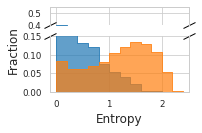

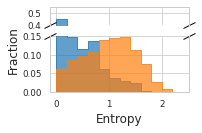

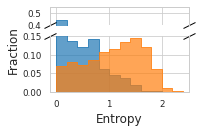

In [14]:
def plot_entropy(results, separate_ID=False):
    common_kwargs = dict(stat='probability', kde=False, bins=12, binrange=[0,2.4], label="dummy", legend=False, element="step", alpha=0.7)
    id_kwargs = dict(
              hue="category", multiple="stack", 
              palette=[sb.color_palette()[0], sb.color_palette()[4]]) if separate_ID else dict(color=sb.color_palette()[0]) 

    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(2.5,2.5/1.6), gridspec_kw={'height_ratios': [1, 3]}, constrained_layout=True)
    fig.subplots_adjust(hspace=0.30)  # adjust space between axes

    for ax in axes:
        sb.histplot(data=results.dirty_mnist, x="entropy", **id_kwargs,
                    **common_kwargs, ax=ax)
        sb.histplot(results.fashion_mnist, color=sb.color_palette()[1],
                    **common_kwargs, ax=ax)

    axes[0].set_ylim(0.4, 0.55)  # outliers only
    axes[1].set_ylim(0, .15)  # most of the data

    axes[0].spines['bottom'].set_visible(False)
    axes[1].spines['top'].set_visible(False)
    axes[0].set_ylabel("")
    axes[1].set_ylabel("Fraction", fontsize=12)
    axes[1].set_xlabel("Entropy", fontsize=12)

    axes[1].yaxis.set_label_coords(-0.04, 0.5, fig.transFigure)

    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    axes[0].plot([0, 1], [0, 0], transform=axes[0].transAxes, **kwargs)
    axes[1].plot([0, 1], [1, 1], transform=axes[1].transAxes, **kwargs)

    fig.set_size_inches(2.5,2.5/1.6)

    return fig, axes

separate_ID = False

plot_entropy(lenet_entropy, separate_ID=separate_ID)
plt.savefig('pdfs/entropy_hist_lenet_dirty_mnist_vs_fmnist.pdf', bbox_inches='tight')
plt.savefig('pngs/entropy_hist_lenet_dirty_mnist_vs_fmnist.png', bbox_inches='tight')

fig, axes = plot_entropy(resnet18_sn_entropy, separate_ID=separate_ID)
plt.savefig('pdfs/entropy_hist_resnet18_sn_dirty_mnist_vs_fmnist.pdf', bbox_inches='tight')
plt.savefig('pngs/entropy_hist_resnet18_sn_dirty_mnist_vs_fmnist.png', bbox_inches='tight')

fig, axes = plot_entropy(vgg16_entropy, separate_ID=separate_ID)
plt.savefig('pdfs/entropy_hist_vgg16_dirty_mnist_vs_fmnist.pdf', bbox_inches='tight')
plt.savefig('pngs/entropy_hist_vgg16_dirty_mnist_vs_fmnist.png', bbox_inches='tight')

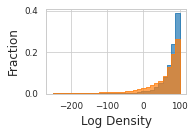

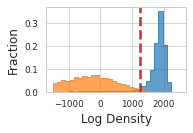

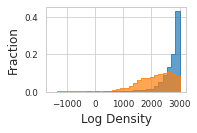

In [15]:
def plot_density(results: Results, binrange, separate_ID=False):
    clrs = ['#1f77b4','#ff7f0e', '#2ca02c','#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22','#17becf']
    sb.set_style('whitegrid')

    plt.figure(figsize=(2.5,2.5/1.6))
    plt.tight_layout()

    range = dict(bins=30, binrange=binrange, element="step", fill=True, alpha=0.7)
    kw_separate_id = dict(hue="category", multiple="stack",
                hue_order=[1, 0],
                palette=[sb.color_palette()[4], sb.color_palette()[0]]) if separate_ID else dict(color=sb.color_palette()[0])

    sb.histplot(data=results.dirty_mnist, x="entropy", **kw_separate_id,
                stat='probability', kde=False, **range, label="dummy", legend=False) # 'Dirty-MNIST (In-distribution)')
    sb.histplot(results.fashion_mnist, color=sb.color_palette()[1],
                stat='probability', kde=False, **range, label="dummy", legend=False) #, label='Fashion-MNIST (OoD)')


    plt.xlabel('Log Density', fontsize=12)
    plt.ylabel('Fraction', fontsize=12)


plot_density(lenet_density, binrange=[-250, 100], separate_ID=separate_ID)
plt.savefig('pdfs/logdensity_hist_lenet_dirty_mnist_vs_fmnist.pdf', bbox_inches='tight')
plt.savefig('pngs/logdensity_hist_lenet_dirty_mnist_vs_fmnist.png', bbox_inches='tight')

plot_density(resnet18_sn_density,  binrange=[-1500, 2500], separate_ID=separate_ID)
plt.axvline(1250, color=clrs[3], linestyle='dashed', linewidth=2.5)
plt.savefig('pdfs/logdensity_hist_resnet18_sn_dirty_mnist_vs_fmnist.pdf', bbox_inches='tight')
plt.savefig('pngs/logdensity_hist_resnet18_sn_dirty_mnist_vs_fmnist.png', bbox_inches='tight')

plot_density(vgg16_density, binrange=[-1500, 3000], separate_ID=separate_ID)
plt.savefig('pdfs/logdensity_hist_vgg16_dirty_mnist_vs_fmnist.pdf', bbox_inches='tight')
plt.savefig('pngs/logdensity_hist_vgg16_dirty_mnist_vs_fmnist.png', bbox_inches='tight')

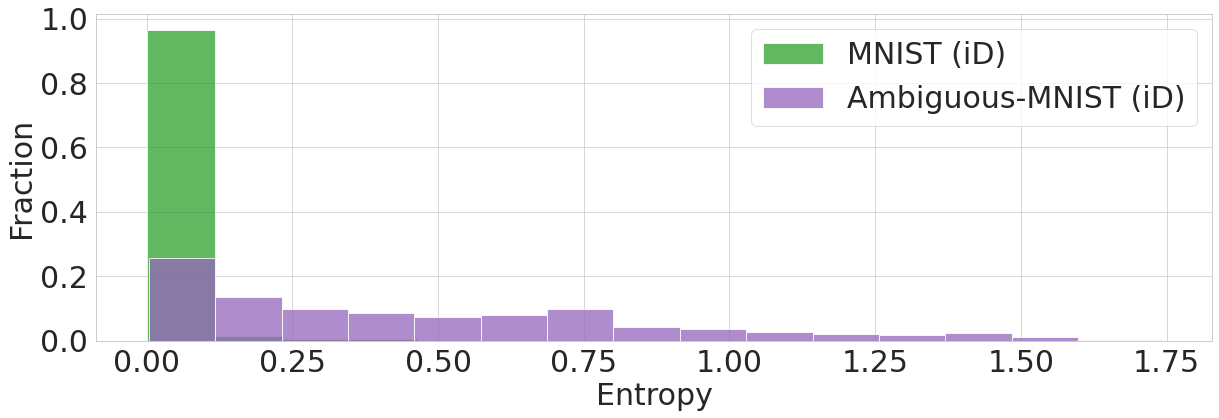

In [25]:
# LeNet entropy plots Figure 1
sb.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (20, 6)
plt.rcParams["legend.loc"] = 'upper right'

sb.histplot(resnet18_sn_mnist_entropies.cpu().numpy(), color=clrs[2], 
            stat='probability', kde=False, bins=15, line_kws = {'linewidth': 8}, label='MNIST (iD)')
sb.histplot(resnet18_sn_ambiguous_mnist_entropies.cpu().numpy(), color=clrs[4], 
            stat='probability', kde=False, bins=15, line_kws = {'linewidth': 8}, label='Ambiguous-MNIST (iD)')

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('Entropy', fontsize=30)
plt.ylabel('Fraction', fontsize=30)
plt.legend(fontsize=30)
plt.savefig('pdfs/entropy_hist_resnet18_sn_dirty_mnist_vs_ambi_mnist.pdf', bbox_inches='tight')
plt.savefig('pngs/entropy_hist_resnet18_sn_dirty_mnist_vs_ambi_mnist.png', bbox_inches='tight')

# Calibration Plot for Dirty-MNIST

In [17]:
from metrics.classification_metrics import test_classification_net
from metrics.calibration_metrics import reliability_plot
from utils.temperature_scaling import ModelWithTemperature

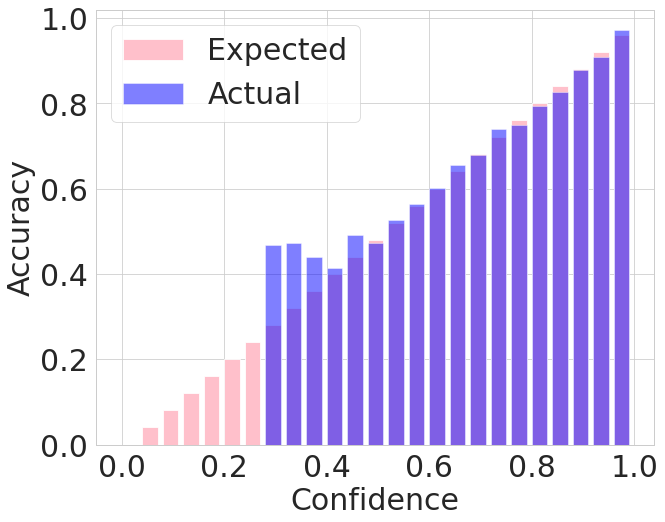

In [18]:
# Reliability plot for LeNet
conf_matrix, accuracy, labels, predictions, confidences = test_classification_net(lenet_model, dirty_mnist_loader, device)
reliability_plot(confidences, predictions, labels, num_bins=25, model_name="lenet")

Before temperature - NLL: 0.282, ECE: 0.011
Optimal temperature: 1.100
After temperature - NLL: 0.280, ECE: 0.013


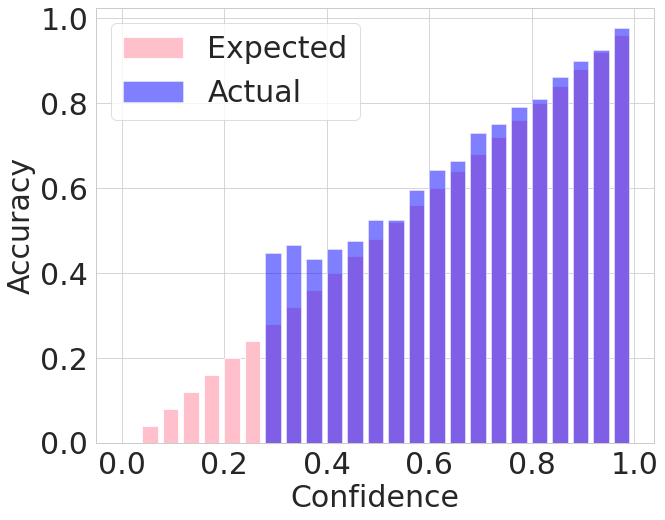

In [19]:
# Reliability plot for LeNet post temp scaling
lenet_temp_model = ModelWithTemperature(lenet_model)
lenet_temp_model.set_temperature(dirty_mnist_val_loader)
conf_matrix, accuracy, labels, predictions, confidences = test_classification_net(lenet_temp_model, dirty_mnist_loader, device)
reliability_plot(confidences, predictions, labels, num_bins=25, model_name="lenet")

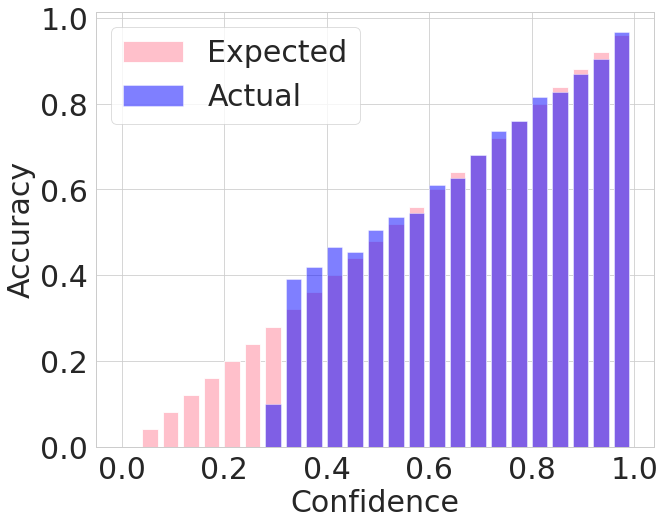

In [20]:
# Reliability plot for ResNet-18_SN
conf_matrix, accuracy, labels, predictions, confidences = test_classification_net(resnet18_sn_model, dirty_mnist_loader, device)
reliability_plot(confidences, predictions, labels, num_bins=25, model_name="resnet18_sn")

Before temperature - NLL: 0.302, ECE: 0.016
Optimal temperature: 1.200
After temperature - NLL: 0.296, ECE: 0.024


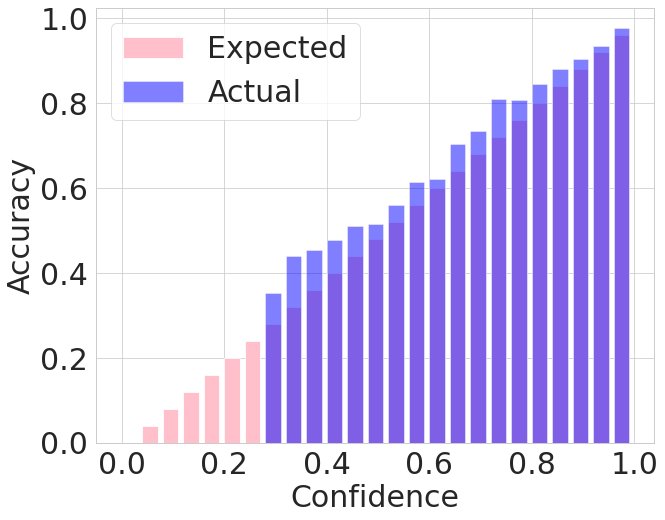

In [21]:
# Reliability plot for resnet18_sn post temp scaling
resnet18_sn_temp_model = ModelWithTemperature(resnet18_sn_model)
resnet18_sn_temp_model.set_temperature(dirty_mnist_val_loader)
conf_matrix, accuracy, labels, predictions, confidences = test_classification_net(resnet18_sn_temp_model, dirty_mnist_loader, device)
reliability_plot(confidences, predictions, labels, num_bins=25, model_name="resnet18_sn")

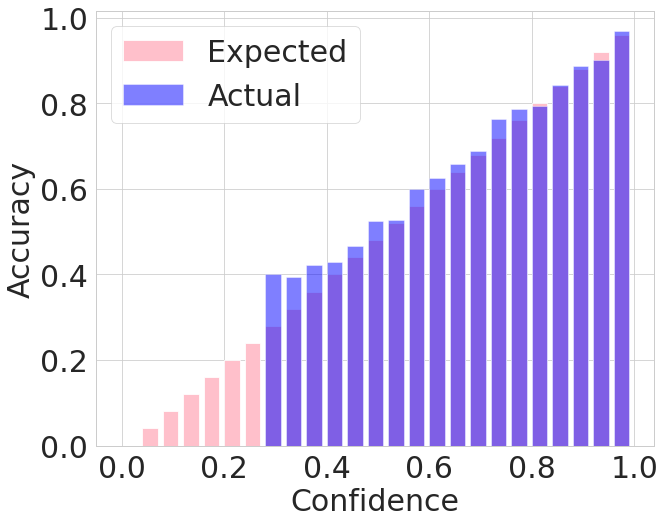

In [22]:
# Reliability plot for ResNet-18_SN
conf_matrix, accuracy, labels, predictions, confidences = test_classification_net(vgg16_model, dirty_mnist_loader, device)
reliability_plot(confidences, predictions, labels, num_bins=25, model_name="vgg16")

Before temperature - NLL: 0.299, ECE: 0.018
Optimal temperature: 1.200
After temperature - NLL: 0.293, ECE: 0.026


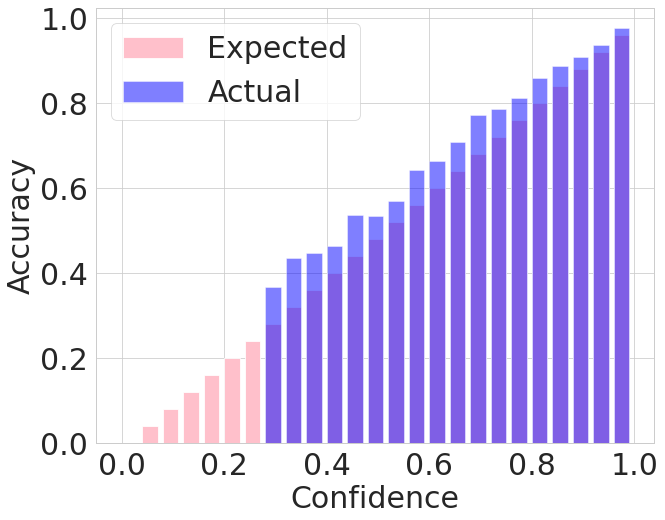

In [23]:
# Reliability plot for vgg16 post temp scaling
vgg16_temp_model = ModelWithTemperature(vgg16_model)
vgg16_temp_model.set_temperature(dirty_mnist_val_loader)
conf_matrix, accuracy, labels, predictions, confidences = test_classification_net(vgg16_temp_model, dirty_mnist_loader, device)
reliability_plot(confidences, predictions, labels, num_bins=25, model_name="vgg16")